In [1]:
import xarray as xr
import geopandas as gpd
import shapely.vectorized as sv
import matplotlib.pyplot as plt
import numpy as np
from rasterio.features import geometry_mask
from rasterio.transform import from_bounds

In [2]:
cf_type = 'csp'
cf_file_path = f'world_{cf_type}_CF_timeseries_2023_#MONTH.nc'

In [3]:
def coarsen_grid(ds, factor_x, factor_y):
    """
    Coarsen the grid of a dataset by a given factor.
    """
    return ds.coarsen(x=factor_x, y=factor_y, boundary='trim').mean()

In [4]:
def plot_capacity_factor(cf_type, dataset_path):
    """
    Plot the capacity factors of the world efficiently.
    """

    # Load dataset lazily
    dataset = xr.open_dataset(dataset_path)
    if 'coarse' in dataset_path:
        dataset = dataset.reindex(x=np.arange(-180, 180.25, 0.25), y=np.arange(-57, 85.25, 0.25), method='nearest')

    
    # Load the world shapefile
    world = gpd.read_file('../input_files/ne_110m_admin_0_countries.shp')

    # Extract the geometry from the GeoSeries (use unary_union if there are multiple polygons)
    region_geom = world.unary_union if len(world) > 1 else world.iloc[0]

    # Get the grid of coordinates (lon, lat) from the xarray DataArray
    lon, lat = np.meshgrid(dataset['x'], dataset['y'])

    # Use shapely's vectorized.contains to create a mask for points within the region
    mask = sv.contains(region_geom, lon, lat)

    # Apply the mask to the dataset DataArray
    dataset = dataset.where(mask)


    # Use imshow for faster plotting
    plt.figure(figsize=(10, 5))
    aspect_ratio = (dataset['x'].max()-dataset['x'].min())/(dataset['y'].max()-dataset['y'].min())
    dataset['capacity factor'].plot(x='x', y='y', aspect=aspect_ratio, size=5, cmap='viridis', vmin=0, vmax=0.2)
    if cf_type == 'solar':
        cf_label = 'solar PV'
    elif cf_type == 'csp':
        cf_label = 'concentrated solar thermal'
    else:
        cf_label = cf_type
    plt.title(f"Capacity factor of {cf_label} (mean of 2023)")
    plt.savefig(f'../figures/{cf_type}_CF_mean_2023.png')


In [5]:
def read_print_dataset(dataset_path):
    # Read and print dataset
    dataset = xr.open_dataset(dataset_path)
    print(dataset)
    # Print some capacity factors
    print(dataset['capacity factor'].values)
    # Close the dataset and release resources
    dataset.close()

In [6]:
# plot_capacity_factor(cf_type, 'half_world_csp/world_csp_CF_mean_2023_job.nc')

<Figure size 1000x500 with 0 Axes>

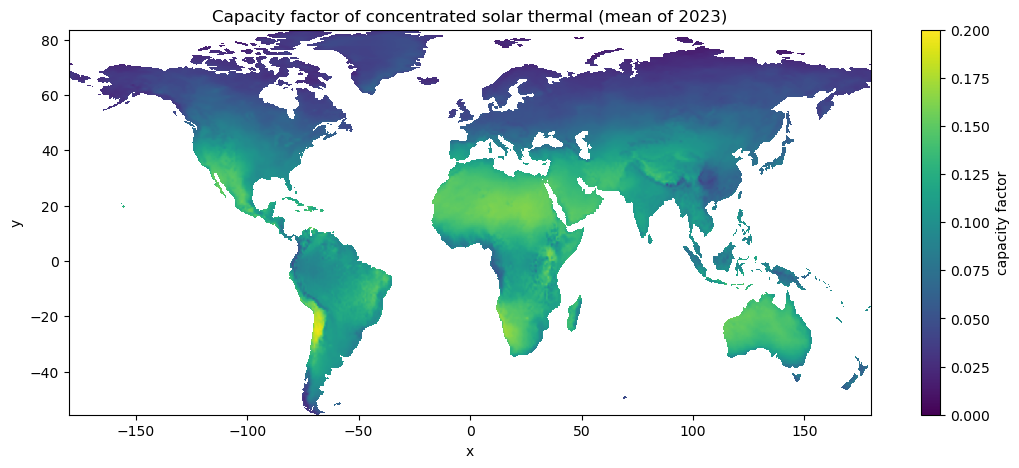

In [8]:
plot_capacity_factor(cf_type, 'atlite_default_global/world_csp_CF_mean_2023_fine.nc')

/tmp/ipykernel_851229/1483072434.py:16: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  region_geom = world.unary_union if len(world) > 1 else world.iloc[0]


<Figure size 1000x500 with 0 Axes>

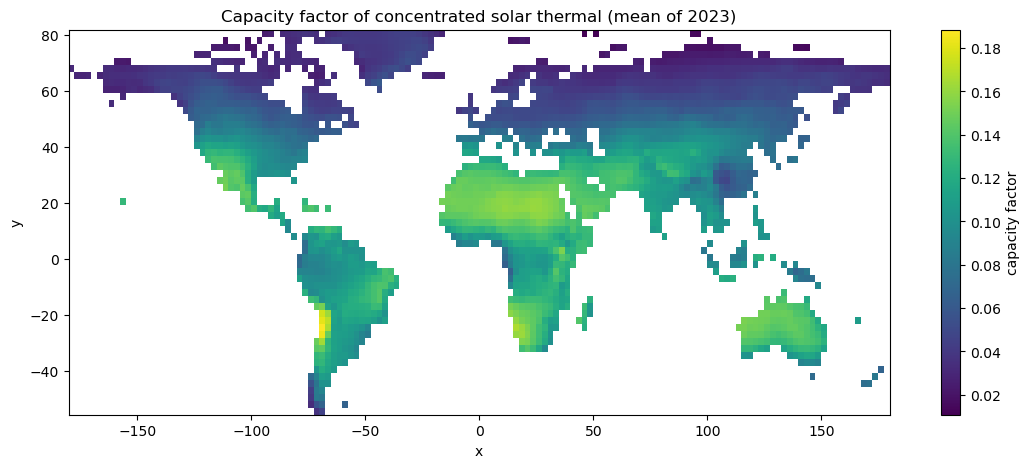

In [ ]:
# Plot annual mean
plot_capacity_factor(cf_type, 'world_csp_CF_mean_2023.nc')

In [ ]:
# plot_capacity_factor('csp', 'old_csp/world_csp_CF_mean_2023_coarse.nc')

In [ ]:
read_print_dataset('world_csp_CF_mean_2023.nc')

<xarray.Dataset> Size: 193kB
Dimensions:          (y: 55, x: 144)
Coordinates:
  * x                (x) float64 1kB -178.9 -176.4 -173.9 ... 173.6 176.1 178.6
  * y                (y) float64 440B -54.38 -51.88 -49.38 ... 75.62 78.12 80.62
    lon              (x) float64 1kB ...
    lat              (y) float64 440B ...
Data variables:
    altitude [deg]   (y, x) float64 63kB ...
    azimuth [deg]    (y, x) float64 63kB ...
    capacity factor  (y, x) float64 63kB ...
[[0.0402284  0.04076639 0.04181206 ... 0.04198915 0.04263292 0.04144675]
 [0.0469195  0.04503879 0.04531474 ... 0.04662444 0.04797721 0.04723488]
 [0.05793502 0.05261801 0.0484071  ... 0.05702423 0.05883909 0.05918255]
 ...
 [0.01332532 0.01307477 0.01313947 ... 0.01397611 0.01385905 0.01359411]
 [0.01224977 0.01165829 0.01141187 ... 0.01334094 0.01309726 0.01271766]
 [0.01080949 0.01049804 0.01052778 ... 0.01135087 0.01132958 0.01116268]]


In [ ]:
# plot_capacity_factor('solar', 'world_solar_CF_mean_2023_job.nc')

In [ ]:
# plot_capacity_factor('csp', 'conus_csp_CF_mean_2023.nc')